# LARS正则化

如果斯坦福大学的Bradley Efron, Trevor Hastie, Iain Johnstone和Robert Tibshirani没有发现它的话[1]，LARS(Least Angle Regression，最小角回归)可能有一天会被你想出来，它借用了[威廉·吉尔伯特·斯特朗（William Gilbert Strang）](https://en.wikipedia.org/wiki/Gilbert_Strang)介绍过的高斯消元法（Gaussian elimination）的灵感。

<!-- TEASER_END -->

## Getting ready

LARS是一种回归手段，适用于解决高维问题，也就是$p >> n$的情况，其中$p$表示列或者特征变量，$n$表示样本数量。

## How to do it...

首先让我们导入必要的对象。这里我们用的数据集是200个数据，500个特征。我们还设置了一个低噪声，和少量提供信息的（informative）特征：

In [ ]:
import numpy as np
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200,n_features=500, n_informative=10, noise=2)

由于我们用了10个信息特征，因此我们还要为LARS设置10个非0的相关系数。我们事先可能不知道信息特征的准确数量，但是出于试验的目的是可行的：

In [2]:
from sklearn.linear_model import Lars
lars = Lars(n_nonzero_coefs=10)
lars.fit(reg_data, reg_target)

Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=10, normalize=True, precompute='auto',
   verbose=False)

我们可以检验一下看看LARS的非0相关系数的和：

In [4]:
np.sum(lars.coef_ != 0)

10

问题在于为什么少量的特征反而变得更加有效。要证明这一点，让我们用一半数量来训练两个LARS模型，一个用12个非零相关系数，另一个非零相关系数用默认值。这里用12个是因为我们对重要特征的数量有个估计，但是可能无法确定准确的数量：

In [14]:
train_n = 100
lars_12 = Lars(n_nonzero_coefs=12)
lars_12.fit(reg_data[:train_n], reg_target[:train_n])

Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=12, normalize=True, precompute='auto',
   verbose=False)

In [13]:
lars_500 = Lars() #默认就是500
lars_500.fit(reg_data[:train_n], reg_target[:train_n])

Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=500, normalize=True, precompute='auto',
   verbose=False)

现在，让我们看看拟合数据的效果如何，如下所示：

In [19]:
np.mean(np.power(reg_target[train_n:] - lars.predict(reg_data[train_n:]), 2))

18.607806437043894

In [18]:
np.mean(np.power(reg_target[train_n:] - lars_12.predict(reg_data[train_n:]), 2))

529.97993250189643

In [17]:
np.mean(np.power(reg_target[train_n:] - lars_500.predict(reg_data[train_n:]), 2))

2.3236770314162846e+34

仔细看看这组结果；测试集的误差明显高很多。高维数据集问题就在于此；通常面对大量的特征时，想找出一个对训练集拟合很好的模型并不难，但是拟合过度却是更大的问题。

## How it works...

LARS通过重复选择与残存变化相关的特征。从图上看，相关性实际上就是特征与残差之间的最小角度；这就是LARS名称的由来。

选择第一个特征之后，LARS会继续沿着最小角的方向移动，直到另一个特征与残差有同样数量的相关性。然后，LARS会沿着两个特征组合的角度移动。如下图所示：

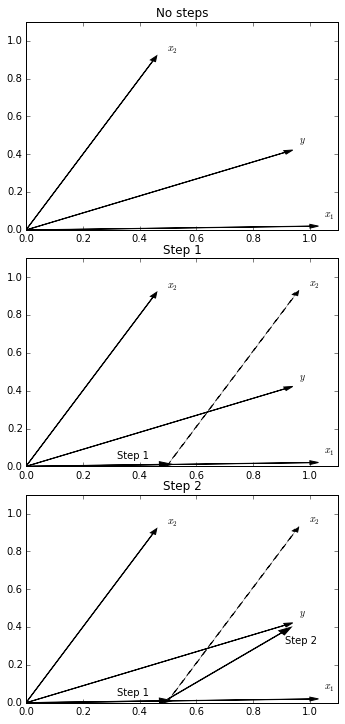

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
def unit(*args):
    squared = map(lambda x: x**2, args)
    distance = sum(squared) ** (.5)
    return map(lambda x: x / distance, args)

f, ax = plt.subplots(nrows=3, figsize=(5, 10))
plt.tight_layout()
ax[0].set_ylim(0, 1.1)
ax[0].set_xlim(0, 1.1)

x, y = unit(1, 0.02)
ax[0].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[0].text(x + .05, y + .05, r"$x_1$")

x, y = unit(.5, 1)
ax[0].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[0].text(x + .05, y + .05, r"$x_2$")

x, y = unit(1, .45)
ax[0].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[0].text(x + .05, y + .05, r"$y$")

ax[0].set_title("No steps")

#step 1
ax[1].set_title("Step 1")
ax[1].set_ylim(0, 1.1)
ax[1].set_xlim(0, 1.1)

x, y = unit(1, 0.02)
ax[1].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[1].text(x + .05, y + .05, r"$x_1$")

x, y = unit(.5, 1)
ax[1].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[1].text(x + .05, y + .05, r"$x_2$")

x, y = unit(.5, 1)
ax[1].arrow(.5, 0.01, x, y, ls='dashed', edgecolor='black', facecolor='black')
ax[1].text(x + .5 + .05, y + .01 + .05, r"$x_2$")

ax[1].arrow(0, 0, .47, .01, width=.0015, edgecolor='black', facecolor='black')
ax[1].text(.47-.15, .01 + .03, "Step 1")

x, y = unit(1, .45)
ax[1].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[1].text(x + .05, y + .05, r"$y$")

#step 2
ax[2].set_title("Step 2")
ax[2].set_ylim(0, 1.1)
ax[2].set_xlim(0, 1.1)

x, y = unit(1, 0.02)
ax[2].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[2].text(x + .05, y + .05, r"$x_1$")

x, y = unit(.5, 1)
ax[2].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[2].text(x + .05, y + .05, r"$x_2$")

x, y = unit(.5, 1)
ax[2].arrow(.5, 0.01, x, y, ls='dashed', edgecolor='black', facecolor='black')
ax[2].text(x + .5 + .05, y + .01 + .05, r"$x_2$")

ax[2].arrow(0, 0, .47, .01, width=.0015, edgecolor='black', facecolor='black')
ax[2].text(.47-.15, .01 + .03, "Step 1")

## step 2
x, y = unit(1, .45)
ax[2].arrow(.5, .02, .4, .35, width=.0015, edgecolor='black', facecolor='black')
ax[2].text(x, y - .1, "Step 2")

x, y = unit(1, .45)
ax[2].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[2].text(x + .05, y + .05, r"$y$");

具体过程是，我们把$x2$沿着$x1$方向移动到一个位置：$x1$与$y$的点积与$x1$与$y$的点积相同。到了这个位置之后，我们再沿着$x1$和$x2$夹角的一半的方向移动。

## There's more...

和我们前面用交叉检验来优化领回归模型一样，我们可以对LARS做交叉检验：

In [9]:
from sklearn.linear_model import LarsCV
lcv = LarsCV()
lcv.fit(reg_data, reg_target)

d:\Miniconda3\lib\site-packages\sklearn\linear_model\least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 168 iterations, i.e. alpha=2.278e-02, with an active set of 132 regressors, and the smallest cholesky pivot element being 6.144e-08
  ConvergenceWarning)
d:\Miniconda3\lib\site-packages\sklearn\linear_model\least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 168 iterations, i.e. alpha=2.105e-02, with an active set of 132 regressors, and the smallest cholesky pivot element being 9.771e-08
  ConvergenceWarning)


LarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16, fit_intercept=True,
    max_iter=500, max_n_alphas=1000, n_jobs=1, normalize=True,
    precompute='auto', verbose=False)

用交叉检验可以帮助我们确定需要使用的非零相关系数的最佳数量。验证如下所示：

In [10]:
np.sum(lcv.coef_ != 0)

43

说实话，LARS的精髓还没有领会，抽空会把原文译出来，看各种解释不如看原文。

[1] Efron, Bradley; Hastie, Trevor; Johnstone, Iain and Tibshirani, Robert(2004). "[Least Angle Regression](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0CB4QFjAAahUKEwjJ3I3ljbDHAhWJlYgKHU2iApA&url=http%3A%2F%2Fweb.stanford.edu%2F~hastie%2FPapers%2FLARS%2FLeastAngle_2002.pdf&ei=ItLRVcnDEImrogTNxIqACQ&usg=AFQjCNFDP4Zjp-cPndzpNhq_8WOwrrui7g&sig2=eNxVG-ZIjnsme93zOTFROw&bvm=bv.99804247,d.cGU)". Annals of Statistics 32(2): pp. 407–499.doi:10.1214/009053604000000067. MR 2060166.